**The objective of our project is to learn the concepts of a CNN and LSTM model and build a working model of Image caption generator by implementing CNN with LSTM.**

**In this Python project, we will be implementing the caption generator using CNN** **(Convolutional Neural Networks) and LSTM (Long short term memory). The image features will be extracted from Xception which is a CNN model trained on the imagenet dataset and then we feed the features into the LSTM model which will be responsible for generating the image captions.**

The Dataset of Python based Project
For the image caption generator, we will be using the Flickr_8K dataset. There are also other big datasets like Flickr_30K and MSCOCO dataset but it can take weeks just to train the network so we will be using a small Flickr8k dataset. The advantage of a huge dataset is that we can build better models.

we get dataset from Kaggle can download it from here also :  [Flicker8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) (Size: 1GB).

**Import Modules**

In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

**os** - used to handle files using system commands.

**pickle** - used to store numpy features extracted

**numpy** - used to perform a wide variety of mathematical operations on arrays

**tqdm** - progress bar decorator for iterators. Includes a default range iterator printing to stderr.

**VGG16, preprocess_input** - imported modules for feature extraction from the image data

**load_img, img_to_array** - used for loading the image and converting the image to a numpy array

**Tokenizer** - used for loading the text as convert them into a token

**pad_sequences** - used for equal distribution of words in sentences filling the remaining spaces with zeros

**plot_model** - used to visualize the architecture of the model through different images

**we set the directories to use the data**

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks'
WORKING_DIR = '/content/drive/MyDrive/Colab Notebooks'

Extract Image Features
We have to load and restructure the model

VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 [==============================] - 26s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

**extracting the image features.**

*   Now we extract the image features and load the data for preprocess

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

FileNotFoundError: ignored

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Extracted features are not stored in the disk, so re-extraction of features can extend running time

Dumps and store our dictionary in a pickle for reloading it to save time


---



In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load all our stored feature data to our project for quicker runtime


---



**Load the Captions Data**


---


Let us store the captions data from the text file

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()



---


Now we split and append the captions data with the image

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/2551 [00:00<?, ?it/s]

*   Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text
*   Same image may have multiple captions, **if image_id not in mapping: mapping[image_id] = []** creates a list for appending captions to the corresponding image


---



## **Preprocess Text Data**

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['667626_18933d713e']

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 '"A young girl is lying in the sand   while ocean water is surrounding her ."',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['667626_18933d713e']

['startseq girl is stretched out in shallow water endseq',
 'startseq girl wearing red and multi-colored bikini is laying on her back in shallow water endseq',
 'startseq little girl in red swimsuit is laying on her back in shallow water endseq',
 'startseq "a young girl is lying in the sand while ocean water is surrounding her ." endseq',
 'startseq girl wearing bikini lying on her back in shallow pool of clear blue water endseq']



---


Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
all_captions[:10]

['startseq man is paddling boat during sunset endseq',
 'startseq man paddles his canoe on the lake endseq',
 'startseq man rows his boat while the sun sets endseq',
 'startseq person in hat reaches with paddle while sitting in canoe on lake endseq',
 'startseq "with the sun reflecting off the water man is sitting in boat and rowing ." endseq',
 'startseq "a black dog emerges from the water onto the sand holding white object in its mouth ." endseq',
 'startseq black dog emerges from the water with white ball in its mouth endseq',
 'startseq black dog on beach carrying ball in its mouth endseq',
 'startseq black dog walking out of the water with white ball in his mouth endseq',
 'startseq the black dog jumps out of the water with something in its mouth endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

29

## **Train Test Split**


---


After preprocessing the data now we will train, test and split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# **Model Creation**

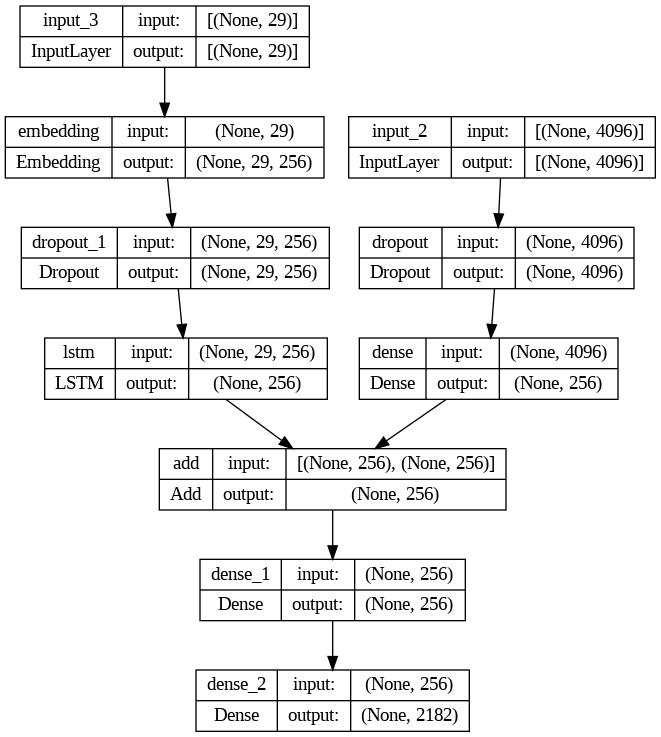

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

**shape=(4096,)** - output length of the features from the VGG model

**Dense** - single dimension linear layer array

**Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

**model.compile()** - compilation of the model

**loss=’sparse_categorical_crossentropy’** - loss function for category outputs

**optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

Model plot shows the concatenation of the inputs and outputs into a single layer

Feature extraction of image was already done using VGG, no CNN model was needed in this step.

## **Train Model**


---


Now lets train the model

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)

Epoch 1/5
14/14 [==============================] - 12s 437ms/step - loss: 6.3489
Epoch 2/5
14/14 [==============================] - 4s 276ms/step - loss: 5.4421
Epoch 3/5
14/14 [==============================] - 4s 269ms/step - loss: 5.1588
Epoch 4/5
14/14 [==============================] - 5s 346ms/step - loss: 4.8703
Epoch 5/5
14/14 [==============================] - 3s 228ms/step - loss: 4.5775
Epoch 1/5
14/14 [==============================] - 2s 169ms/step - loss: 4.3025
Epoch 2/5
14/14 [==============================] - 2s 165ms/step - loss: 4.0150
Epoch 3/5
14/14 [==============================] - 3s 208ms/step - loss: 3.7638
Epoch 4/5
14/14 [==============================] - 3s 223ms/step - loss: 3.5920
Epoch 5/5
14/14 [==============================] - 2s 166ms/step - loss: 3.4539
Epoch 1/5
14/14 [==============================] - 2s 172ms/step - loss: 3.3208
Epoch 2/5
14/14 [==============================] - 2s 172ms/step - loss: 3.0371
Epoch 3/5
14/14 [======================

steps = len(train) // batch_size - back propagation and fetch the next data

Loss decreases gradually over the iterations

Increase the no. of epochs for better results

Assign the no. of epochs and batch size accordingly for quicker results

### **We can save the model in the working directory for reuse**

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

## **Generate Captions for the Image**

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

### **Convert the predicted index from the model into a word**

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

# **Model Validation**


---


### **Now we validate the data using BLEU Score**

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/51 [00:00<?, ?it/s]

BLEU-1: 0.509677
BLEU-2: 0.315321


BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

The reference text contains all the words appended from the captions data (actual_captions)

A BLEU Score more than **0.4 is considered a good result**, for a better score increase the no. of epochs accordingly.

## **Visualize the Results**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)



*   Image caption generator defined
*   First prints the actual captions of the image then prints a predicted caption of the image

---------------------Actual---------------------
startseq man is standing on top of mountain gazing at the sunset endseq
startseq man is standing on top of rock or mountain watching the sunset endseq
startseq man 's sillouhette at sunset endseq
startseq man standing in the mountains watching sunset endseq
startseq man stands on hill at dusk endseq
--------------------Predicted--------------------
startseq man is standing on top of rock or mountain watching the sunset endseq


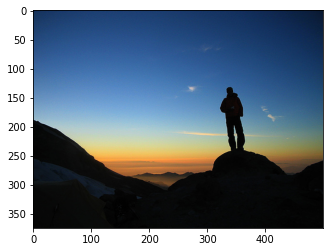

In [ ]:
generate_caption("58368365_03ed3e5bdf.jpg")

---------------------Actual---------------------
startseq boy in black helmet and red long sleeve shirt rides his motorbike over rocky stream endseq
startseq man on motorcycle steers through swampy terrain endseq
startseq man rides his bike over rocks and creek endseq
startseq motocross bike is being ridden between markers in running stream endseq
startseq person is dirt biking over rocks and water endseq
--------------------Predicted--------------------
startseq motocross bike is being ridden between markers in running stream endseq


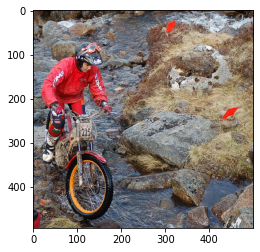

In [ ]:
generate_caption("143552829_72b6ba49d4.jpg")

---------------------Actual---------------------
startseq beautiful sunset with three people in boat on the lake endseq
startseq as the sunsets people are on small boat enjoying the view endseq
startseq three people are in canoe on calm lake with the sun reflecting yellow endseq
startseq three people are on boat in the middle of the water while the sun is in the back endseq
startseq three people in boat float on the water at sunset endseq
--------------------Predicted--------------------
startseq three people are in boat float on the middle of the middle of the middle of the sun is in the back endseq


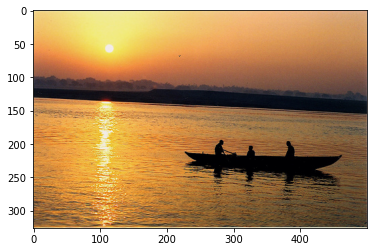

In [ ]:
generate_caption("223299137_b0e81ac145.jpg")

---------------------Actual---------------------
startseq black and brown dog staring off into the distance at something endseq
startseq "a black brown and tan dog jumps at the camera ." endseq
startseq brown dog running through tall grass endseq
startseq dog in plants crouches to look at camera endseq
startseq the black and white dog is running through the bushes endseq
--------------------Predicted--------------------
startseq the black and brown dog is running at the bushes at the bushes endseq


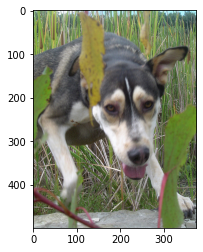

In [ ]:
generate_caption("233361142_d9d5f0cae9.jpg")

---------------------Actual---------------------
startseq three men standing in the tide at beach endseq
startseq "three men stand on the beach fully clothed ." endseq
startseq three men wade into the ocean shore endseq
startseq three people in jackets at rocky beach endseq
startseq three people on beach endseq
--------------------Predicted--------------------
startseq three men in jackets at rocky beach endseq


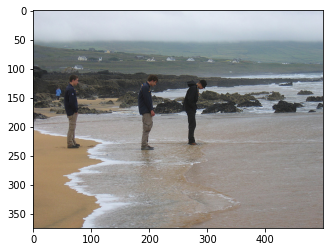

In [ ]:
generate_caption("244760289_f4467b2b67.jpg")

**Final Thoughts**

1.   Training the model by increasing the no. of epochs can give better and more accurate results.
2.   Processing large amount of data can take a lot of time and system resource.
3.   The no. of layers of the model can be increased if we want to process large dataset.
4.   In this project , we have built an Image Caption Generator exploring the coco Dataset as an advanced deep learning project using different models from image extraction and text based processing.

